# 0. Imports

## 0.1. Libraries and configs

In [1]:
# Bult-in
import os
from sys import path
path.append(os.path.join(".."))
from typing import Dict, List, Sequence

# Installed
from inflection import underscore
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin, RegressorMixin
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics as m

# Custom
from src.utils import set_jupyter_settings
set_jupyter_settings(filterwarnings=True)
from src.database.data_ingestion import ingest_data_into_database

[02/26/23 11:51:24] INFO     Jupyter has been successfully configured.                                  ]8;id=271493;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/utils.py\utils.py]8;;\:]8;id=536110;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/utils.py#57\57]8;;\

In [2]:
CONNECTION_STRING: str | None = os.getenv("CONNECTION_STRING")
DATA_DIR: str = os.path.join("..", "data")

## 0.2. Helper functions

## 0.3. Data acquisition
Data source: [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [3]:
ingest_data_into_database(
    connection_string=CONNECTION_STRING,
    data_directory=DATA_DIR,
    files=[
        "green_tripdata_2022-01.parquet",
        "green_tripdata_2022-02.parquet",
    ]
)

[02/26/23 11:51:36] INFO     Ingesting 131894 records into the database...                     ]8;id=499748;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py\data_ingestion.py]8;;\:]8;id=375441;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py#26\26]8;;\

[02/26/23 11:51:51] INFO     Data ingestion completed.                                         ]8;id=146039;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py\data_ingestion.py]8;;\:]8;id=295528;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py#69\69]8;;\

In [26]:
raw_data: pd.DataFrame = pd.read_sql("SELECT * FROM green_taxi", CONNECTION_STRING)
raw_data.sample(3)

,id,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
83995,83996,2,2022-02-10 18:54:42,2022-02-10 19:23:03,N,1.0,260,83,1.0,1.80,17.5,1.0,0.5,0.00,0.0,None,0.3,19.30,2.0,1.0,0.0
12371,12372,2,2022-01-07 20:19:22,2022-01-07 20:28:50,N,1.0,95,28,1.0,1.89,8.5,0.5,0.5,2.45,0.0,None,0.3,12.25,1.0,1.0,0.0
128751,128752,2,2022-02-15 21:10:00,2022-02-15 21:23:00,None,None,74,116,NaN,3.05,14.1,0.0,0.0,3.20,0.0,None,0.3,17.60,None,None,NaN


# 1. Data cleansing and description

## Data dictionary
Link: [Data dictionary trip records green](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

## 1.1. Rename columns

In [27]:
raw_data.columns = [underscore(column) for column in raw_data.columns]

## 1.2. Data dimensions

In [28]:
print(
    f"""
    Number of columns: {raw_data.shape[1]}
    Number of rows: {raw_data.shape[0]:,}
    """
)


    Number of columns: 21
    Number of rows: 131,894
    


## 1.3. Duplicate data

In [29]:
raw_data.duplicated().sum()

0

## 1.4. Data types

In [30]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131894 entries, 0 to 131893
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     131894 non-null  int64         
 1   vendor_id              131894 non-null  object        
 2   lpep_pickup_datetime   131894 non-null  datetime64[ns]
 3   lpep_dropoff_datetime  131894 non-null  datetime64[ns]
 4   store_and_fwd_flag     118178 non-null  object        
 5   ratecode_id            118178 non-null  object        
 6   pu_location_id         131894 non-null  object        
 7   do_location_id         131894 non-null  object        
 8   passenger_count        118178 non-null  float64       
 9   trip_distance          131894 non-null  float64       
 10  fare_amount            131894 non-null  float64       
 11  extra                  131894 non-null  float64       
 12  mta_tax                131894 non-null  floa

## 1.5. Missing data

In [31]:
raw_data.isna().sum()

id                            0
vendor_id                     0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag        13716
ratecode_id               13716
pu_location_id                0
do_location_id                0
passenger_count           13716
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                131894
improvement_surcharge         0
total_amount                  0
payment_type              13716
trip_type                 13716
congestion_surcharge      13716
dtype: int64

In [32]:
remove_rows_because_of_null_values: List[str] = [
    "store_and_fwd_flag", "passenger_count",
    "payment_type", "trip_type", "congestion_surcharge"
]
raw_data.dropna(subset=remove_rows_because_of_null_values, axis=0, inplace=True)

## 1.6. Outliers

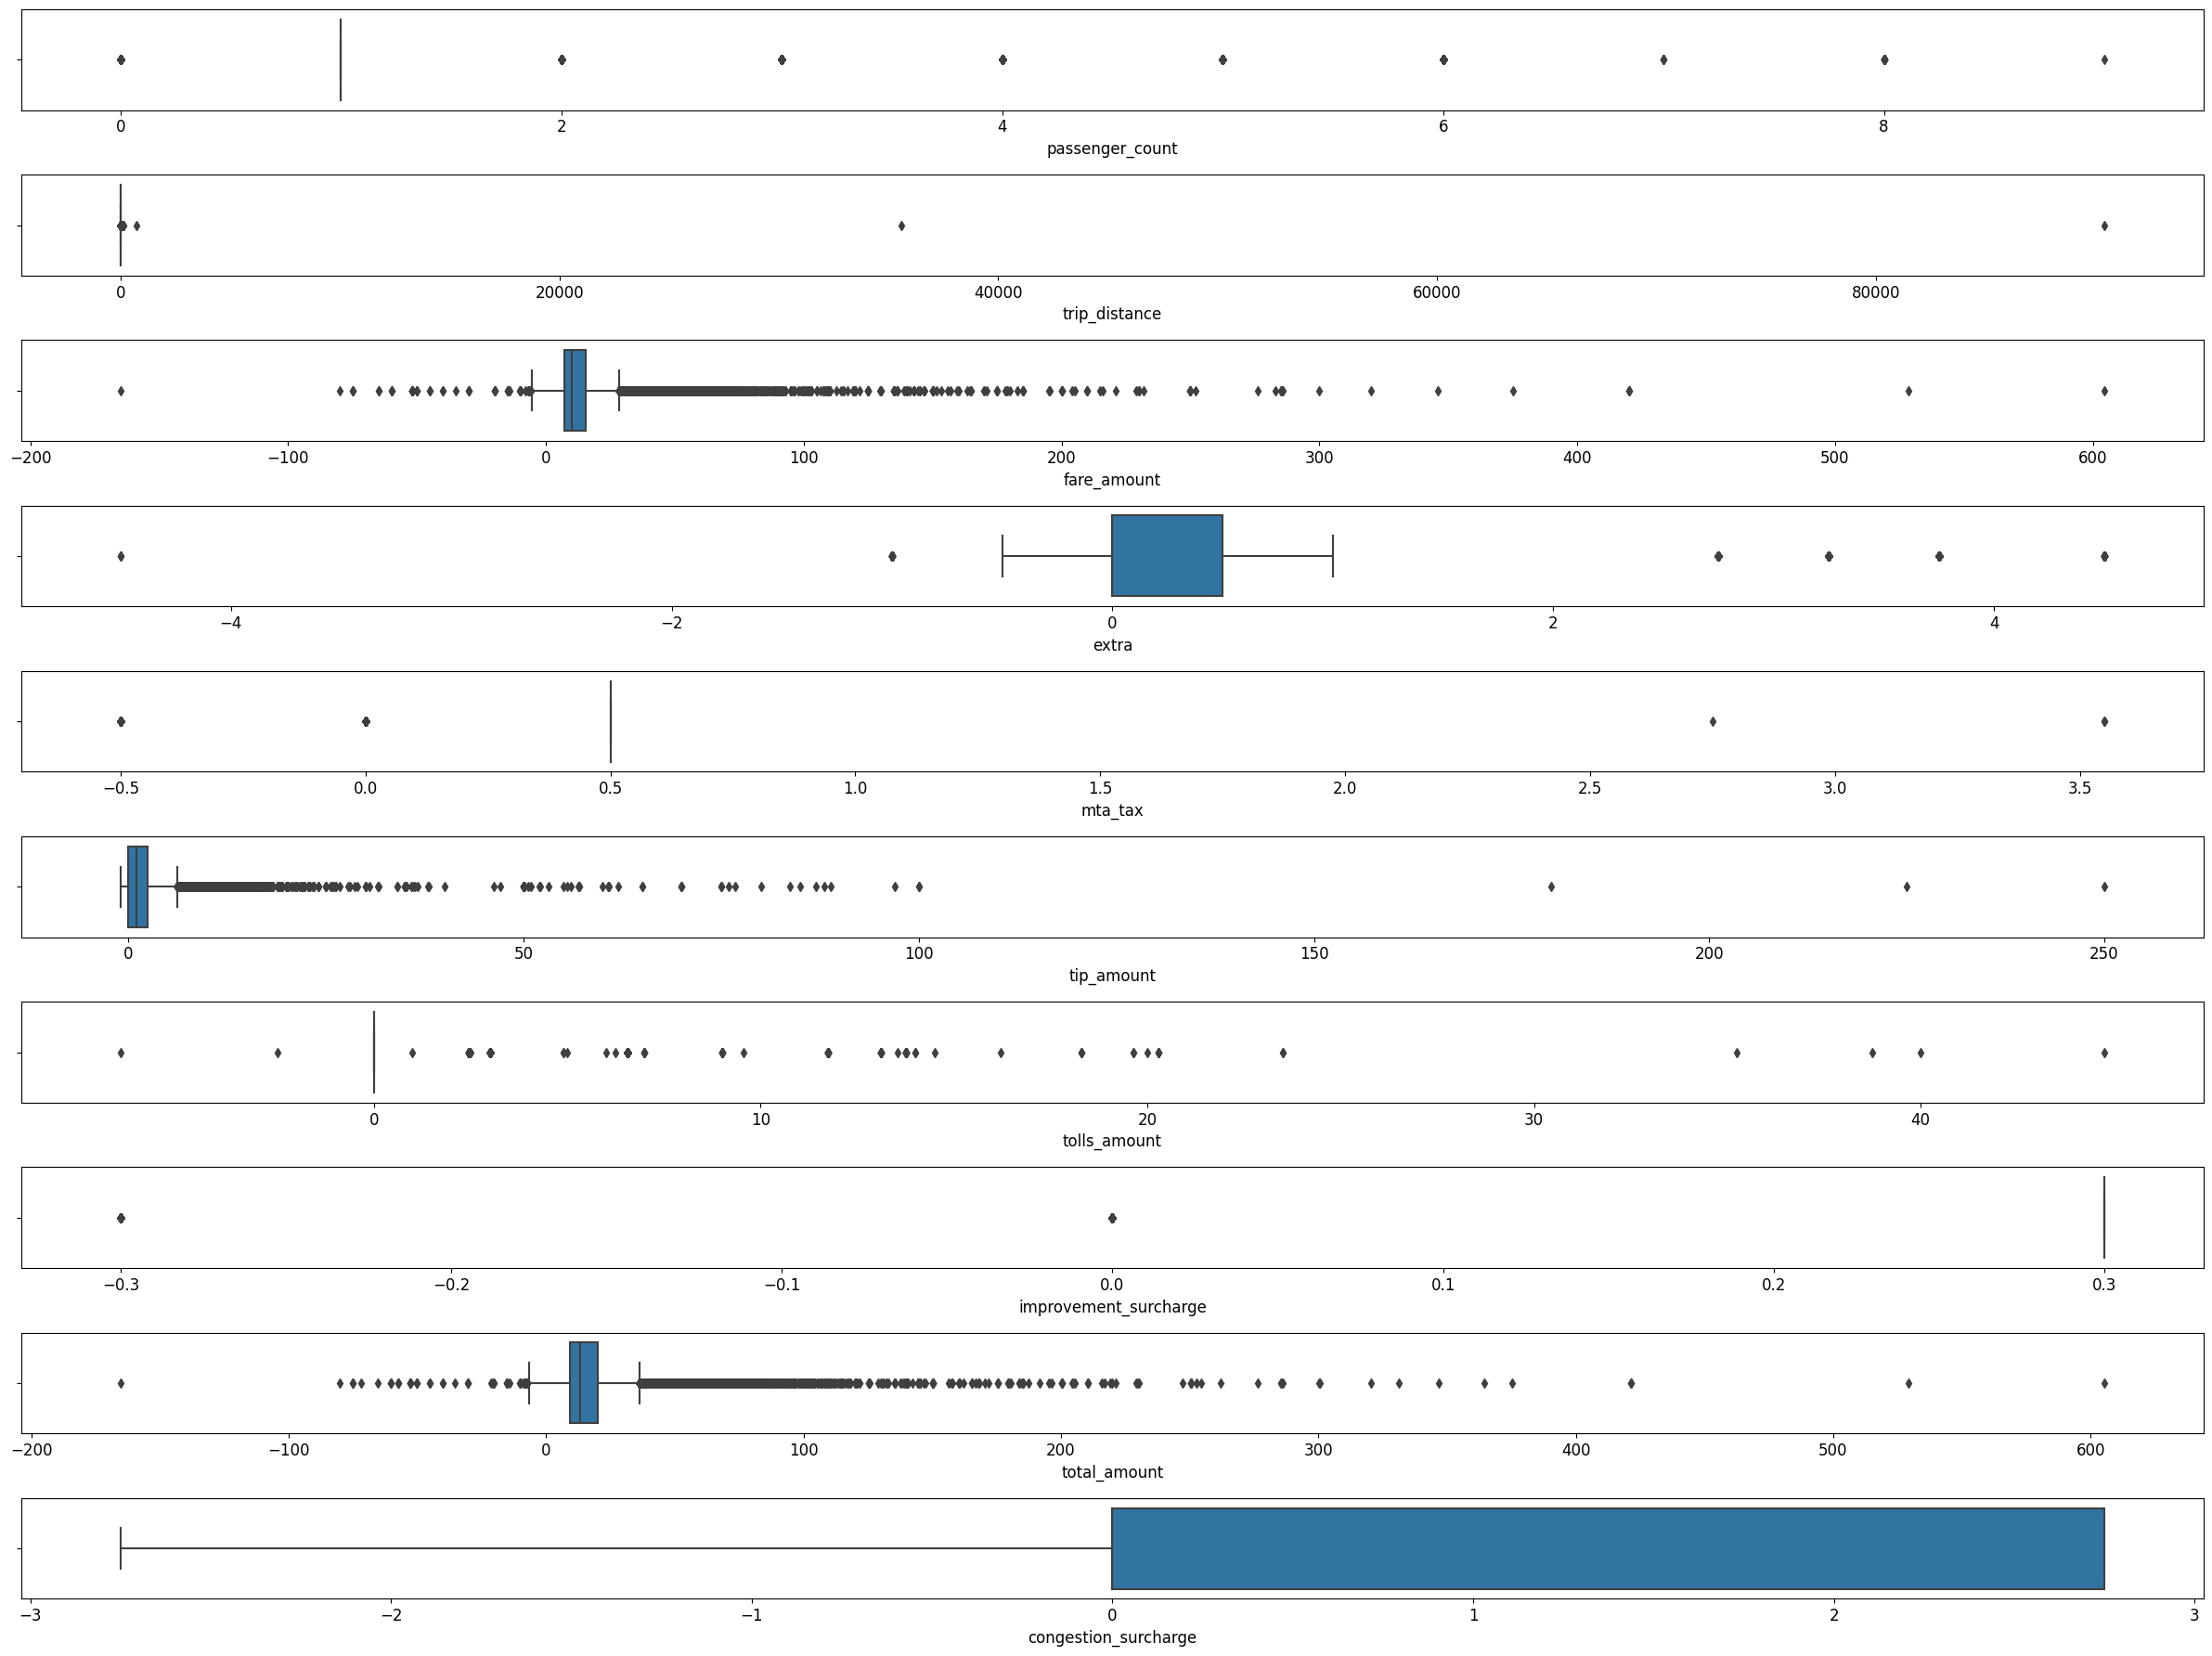

In [33]:
might_have_outlier_columns: List[str] = [
    "passenger_count", "trip_distance", "fare_amount",
    "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "total_amount", "congestion_surcharge"
]
_, ax = plt.subplots(
    nrows=len(might_have_outlier_columns),
    ncols=1,
    figsize=(24,18)
)
for idx, column in enumerate(might_have_outlier_columns):
    sns.boxplot(x=column, data=raw_data, ax=ax[idx]);
    plt.tight_layout()

In [34]:
print(f"Before: {len(raw_data):,}")
for column in might_have_outlier_columns:
    q75, q25 = np.percentile(raw_data.loc[:, column], 75), np.percentile(raw_data.loc[:, column], 25)
    iqr: float = q75 - q25
    cut_off: float = 1.5 * iqr # 1.5 outlier rule
    lower, upper = q25 - cut_off, q75 + cut_off
    mask: List[bool] = [False if x < lower or x > upper else True for x in raw_data.loc[:, column]]
    raw_data: pd.DataFrame = raw_data.loc[mask, :]
print(f"After: {len(raw_data):,}")

Before: 118,178
After: 63,337


## 1.7. Descriptive statistics

In [35]:
numerical_attributes: pd.DataFrame = raw_data.select_dtypes(include=["int", "float"])
categorical_attributes: pd.DataFrame = raw_data.select_dtypes(include=["object", "category"])

### 1.7.1. Numerical attributes

In [36]:
# Calculate central tendency and dispersion metrics
numerical_attributes_description = pd.DataFrame({
    "Mean": numerical_attributes.apply(np.mean),
    "Median": numerical_attributes.apply(np.median),
    "Std. deviation": numerical_attributes.apply(np.std),
    "Min": numerical_attributes.apply(np.min),
    "Max": numerical_attributes.apply(np.max),
    "Range": numerical_attributes.apply(lambda x: np.max(x) - np.min(x)),
    "Skew": numerical_attributes.apply(lambda x: x.skew()),
    "Kurtosis": numerical_attributes.apply(lambda x: x.kurtosis())
})
numerical_attributes_description

,Mean,Median,Std. deviation,Min,Max,Range,Skew,Kurtosis
id,62001.834567,65005.00,3.665450e+04,1.0,124472.00,124471.00,-0.002809,-1.273839
passenger_count,1.000000,1.00,0.000000e+00,1.0,1.00,0.00,0.000000,0.000000
trip_distance,1.721834,1.43,1.190340e+00,0.0,6.43,6.43,1.271246,1.721701
fare_amount,9.188221,8.00,4.251891e+00,0.0,24.00,24.00,1.006917,0.665416
extra,0.302019,0.00,4.098310e-01,0.0,1.00,1.00,0.842958,-0.990026
mta_tax,0.500000,0.50,0.000000e+00,0.5,0.50,0.00,0.000000,0.000000
tip_amount,0.992139,0.00,1.241929e+00,0.0,5.75,5.75,1.019500,0.238969
tolls_amount,0.000000,0.00,0.000000e+00,0.0,0.00,0.00,0.000000,0.000000
improvement_surcharge,0.300000,0.30,5.551115e-17,0.3,0.30,0.00,0.000000,0.000000
total_amount,11.282842,10.30,4.629831e+00,0.8,28.00,27.20,0.850760,0.386300


### 1.7.2. Categorical attributes

In [37]:
categorical_attributes.describe().T

,count,unique,top,freq
vendor_id,63337,2,2,53313
store_and_fwd_flag,63337,2,N,62650
ratecode_id,63337,5,1.0,63257
pu_location_id,63337,185,74,11394
do_location_id,63337,217,74,5410
ehail_fee,0,0,NaN,NaN
payment_type,63337,4,1.0,35122
trip_type,63337,2,1.0,63326


# 2. Feature engineering

## 2.1. Phenomenon modeling

In [38]:
raw_data["duration"] = raw_data.loc[:, "lpep_dropoff_datetime"] - raw_data.loc[:, "lpep_pickup_datetime"]
raw_data["duration"] = raw_data.loc[:, "duration"].dt.seconds / 60

In [39]:
raw_data["location_id"] = raw_data.loc[:, "pu_location_id"] + raw_data.loc[:, "do_location_id"]
raw_data["price_per_meter"] = raw_data.loc[:, "trip_distance"] / (raw_data.loc[:, "fare_amount"] + 1)
raw_data["tax_per_meter"] = raw_data.loc[:, "trip_distance"] * raw_data.loc[:, "mta_tax"]
raw_data["total_amount_per_extra"] = raw_data.loc[:, "total_amount"] / (raw_data.loc[:, "extra"] + 1)

## 2.2. Filtering

In [40]:
irrelevant_columns_to_drop: List[str] = [
    "ehail_fee", "passenger_count", "tolls_amount",
    "improvement_surcharge", "congestion_surcharge"
]
raw_data.drop(irrelevant_columns_to_drop, axis=1, inplace=True)

In [45]:
raw_data = raw_data.loc[(raw_data.loc[:, "duration"] >= 1) & (raw_data.loc[:, "duration"] <= 60), :]

## Checkpoint

In [48]:
CHECKPOINT_DIR: str = os.path.join(DATA_DIR, "interim", "cleaned_train_data.parquet")
raw_data.to_parquet(CHECKPOINT_DIR)
del raw_data # Remove dirty data from memory
df: pd.DataFrame = pd.read_parquet(CHECKPOINT_DIR)

In [50]:
df.sample(3)

,id,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,trip_distance,fare_amount,extra,mta_tax,tip_amount,total_amount,payment_type,trip_type,duration,location_id,price_per_meter,tax_per_meter,total_amount_per_extra
83859,83860,2,2022-02-10 18:32:54,2022-02-10 18:43:23,N,1.0,166,41,1.26,8.0,1.0,0.5,0.0,9.8,2.0,1.0,10.483333,16641,0.140000,0.630,4.900000
23687,23688,2,2022-01-14 00:08:22,2022-01-14 00:18:33,N,1.0,83,56,1.83,9.0,0.5,0.5,0.0,10.3,2.0,1.0,10.183333,8356,0.183000,0.915,6.866667
122483,122484,2,2022-02-28 08:17:56,2022-02-28 08:28:20,N,1.0,74,166,1.39,8.5,0.0,0.5,0.0,9.3,1.0,1.0,10.400000,74166,0.146316,0.695,9.300000


# 3. Exploratory data analysis

In [3]:
# def preprocess_data(X: pd.DataFrame) -> np.ndarray:
#     return DictVectorizer(sparse=False).fit_transform(
#         X.to_dict(orient="records")
#     )

# def train_model(
#     X_train: np.ndarray,
#     y_train: np.ndarray | pd.Series,
#     model: RegressorMixin = HistGradientBoostingRegressor()
# ) -> RegressorMixin:
#     return model.fit(X_train, y_train)

# def evaluate_model(
#     y_val: np.ndarray | pd.Series,
#     y_hat: np.ndarray | pd.Series
# ) -> Dict[str, Dict[str, float]]:
#     return {
#         "metrics": {
#                 "rmse": m.mean_squared_error(y_val, y_hat, squared=False),
#                 "mape": m.mean_absolute_percentage_error(y_val, y_hat)
#             },
#         }